In [1]:
#Derek Zhang 026225028
#Markov Chain Monte Carlo

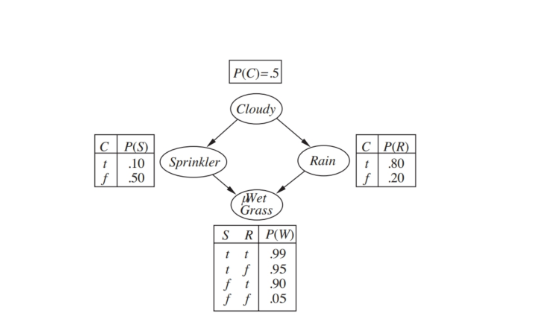

Figure 1

In [2]:
import random

In [83]:
#My initial method will attempt to provide a general solution to the problem via simulation. 
prob_c = 0.5  # P(C=true)
prob_s_given_c = {True: 0.1, False: 0.5}  # P(S=true|C)
prob_r_given_c = {True: 0.8, False: 0.2}  # P(R=true|C)
prob_w_given_s_r = {(True, True): 0.99, (True, False): 0.9, (False, True): 0.9, (False, False): 0.0}  # P(W=true|S,R)



#We need to count the probability of all of these with the MCMC function




In [85]:
#Part A: Show P(C|~s, r), P(C|~s, ~r), P(R|c,~s,w), P(R|~c, ~s, w)

#MCMC for 1a part 1 and 2
def estimate_prob_c_given_s_r(sprinkler_state, rain_state, samples=1000000):
    C = random.choice([True, False])  # Initial state for C (Cloudy)
    count_c_true = 0

    for _ in range(samples):
        # Proposal: Flip the state of C
        proposed_C = not C
        
        # Calculate acceptance ratio
        current_prob = (prob_c if C else 1 - prob_c) * prob_r_given_c[C]
        proposed_prob = (prob_c if proposed_C else 1 - prob_c) * prob_r_given_c[proposed_C]
        
        # Acceptance probability
        acceptance_prob = min(1, proposed_prob / current_prob)
        
        # Accept or reject the new state
        if random.uniform(0, 1) < acceptance_prob:
            C = proposed_C
        
        # If the proposed state matches our conditions (S and R), count it
        if C and (sprinkler_state is None or sprinkler_state == (prob_s_given_c[C] > 0.1)) and rain_state == rain_state:
            count_c_true += 1

    return count_c_true / samples

#output
# Estimate P(C|¬s, r)
prob_c_given_not_s_r = estimate_prob_c_given_s_r(False, True)
prob_c_given_s_r = estimate_prob_c_given_s_r(True, True)
print(f"Estimated P(C|¬s, r): <{prob_c_given_not_s_r:.4f}, {prob_c_given_s_r:.4f}>")

# Estimate P(C|¬s, ¬r)
prob_c_given_not_s_not_r = estimate_prob_c_given_s_r(False, False)
prob_c_given_s_not_r = estimate_prob_c_given_s_r(True, False)
print(f"Estimated P(C|¬s, ¬r): <{prob_c_given_not_s_not_r:.4f}, {prob_c_given_s_not_r:.4f}>")

def estimate_prob_r_given_c_s_w(cloud_state, sprinkler_state, wetgrass_state, samples=1000000):
    # Initial state for R (Rain)
    R = random.choice([True, False])
    count_r_true = 0
    count_samples_considered = 0

    for _ in range(samples):
        # Fix C to True (cloudy) and S to False (sprinkler not on) for the given conditions
        C = cloud_state
        S = sprinkler_state
        
        # Calculate the current probability of Wet Grass given S and R
        current_prob_w = prob_w_given_s_r[(S, R)]
        
        # Proposal: Flip the state of R
        proposed_R = not R
        proposed_prob_w = prob_w_given_s_r[(S, proposed_R)]
        
        # Calculate acceptance ratio
        current_prob = prob_r_given_c[C] if R else 1 - prob_r_given_c[C]
        proposed_prob = prob_r_given_c[C] if proposed_R else 1 - prob_r_given_c[C]
        if current_prob == 0 or current_prob_w == 0:
            acceptance_prob = 1
        else:
            acceptance_prob = min(1, (proposed_prob * proposed_prob_w) / (current_prob * current_prob_w))
        
        # Accept or reject the new state
        if random.uniform(0, 1) < acceptance_prob:
            R = proposed_R
        
        # Only consider samples where the grass is wet
        if current_prob_w > 0:
            count_samples_considered += 1
            if R:
                count_r_true += 1

    # Return the conditional probability P(R|c, ¬s, w)
    return count_r_true / count_samples_considered if count_samples_considered else 0
    
# Estimate P(R|c, ¬s, w)
prob_r_given_c_not_s_w = estimate_prob_r_given_c_s_w(True, False, True)
prob_r_given_c_s_w = estimate_prob_r_given_c_s_w(True, True, True)
print(f"Estimated P(R|c, ¬s, w): <{1-prob_r_given_c_s_w:.4f}, {prob_r_given_c_s_w:.4f}>")
# Estimate P(R|¬c, ¬s, w)
prob_r_given_not_c_not_s_w = estimate_prob_r_given_c_s_w(False, False, True)
prob_r_given_not_c_s_w = estimate_prob_r_given_c_s_w(False, True, True)
print(f"Estimated P(R|¬c, ¬s, w): <{1-prob_r_given_not_c_s_w:.4f}, {prob_r_given_not_c_s_w:.4f}>")


Estimated P(C|¬s, r): <0.8003, 0.0000>
Estimated P(C|¬s, ¬r): <0.8003, 0.0000>
Estimated P(R|c, ¬s, w): <0.1851, 0.8149>
Estimated P(R|¬c, ¬s, w): <0.7845, 0.2155>


In [92]:
#Part B: Show the transition probability matrix Q exists in R^4x4 where q_ij=transition probability from state i to state j in Figure 2

Q = [[0 for _ in range(4)] for _ in range(4)]

#S1
#(c,r) -> (c,r)
Q[0][0] = prob_c * prob_r_given_c[True]
#(c,r) -> (c,~r)
Q[0][1] = prob_c * (1 - prob_r_given_c[True])
#(c,r) -> (~c,r)
Q[0][2] = (1 - prob_c) * prob_r_given_c[False]
#(c,r) -> (~c,~r)
Q[0][3] = 0

#S2
#(c,~r) -> (c,r)
Q[1][0] = prob_c * prob_r_given_c[True]
#(c,~r) -> (c,~r)
Q[1][1] = prob_c * (1 - prob_r_given_c[True])
#(c,~r) -> (~c,r)
Q[1][2] = 0
#(c,~r) -> (~c,~r)
Q[1][3] = (1 - prob_c) * (1 - prob_r_given_c[False])

#S3
#(~c,r) -> (c,r)
Q[2][0] = prob_c * prob_r_given_c[True]
#(~c,r) -> (c,~r)
Q[2][1] = 0
#(~c,r) -> (~c,r)
Q[2][2] = (1 - prob_c) * prob_r_given_c[False]
#(~c,r) -> (~c,~r)
Q[2][3] = (1 - prob_c) * (1 - prob_r_given_c[False])

#S4
#(~c,~r) -> (c,r)
Q[3][0] = 0
#(~c,~r) -> (c,~r)
Q[3][1] = prob_c * (1 - prob_r_given_c[True])
#(~c,~r) -> (~c,r)
Q[3][2] = (1 - prob_c) * prob_r_given_c[False]
#(~c,~r) -> (~c,~r)
Q[3][3] = (1 - prob_c) * (1 - prob_r_given_c[False])

normalization = []
for i in range(4):
    added = 0
    for j in range(4):
        added += Q[i][j]
    normalization.append(added)
    
        

for i in range(4):
    for q in range(4):
        print(f"{Q[i][q]/normalization[i]:.4f}", end=" ")
    print()




0.6667 0.1667 0.1667 0.0000 
0.4444 0.1111 0.0000 0.4444 
0.4444 0.0000 0.1111 0.4444 
0.0000 0.1667 0.1667 0.6667 


In [94]:
#Part C: Show the probability of the query P(C|~s, w)

#MCMC for 1c
def mcmc(samples = 1000000):
    s1count = 0
    s2count = 0
    s3count = 0
    s4count = 0
    current = [random.choice([True, False]), False, random.choice([True, False]), True]
    for _ in range(samples):
        chosen = random.randint(0,1)
        next = random.random()
        if chosen == 0:
            if next < 0.5:
                current[0] = True
            else:
                current[0] = False
        elif chosen == 1:
            if next < 0.5:
                current[2] = True
            else:
                current[2] = False
        
        if current == [True, False, True, True]:
            s1count +=1
        elif current == [True, False, False, True]:
            s2count+=1
        elif current == [False, False, True, True]:
            s3count+=1
        elif current == [False, False, False, True]:
            s4count+=1
    return [s1count/samples, s2count/samples, s3count/samples, s4count/samples]

#output
# Estimate P(C|¬s, w)
s2count = mcmc()[1]
print(f"Estimated P(C|¬s, w): <{s2count:.4f},{1-s2count:.4f}", end="")

            


Estimated P(C|¬s, w): <0.2506,0.7494